# Import

https://www.kaggle.com/datasets/elikplim/concrete-compressive-strength-data-set
https://www.kaggle.com/datasets/elikplim/eergy-efficiency-dataset
https://www.kaggle.com/datasets/gova26/airpressure

# Estudo inicial GNN - Hiperparâmetros e convergência

In [1]:
from diagnostics import GNN_analysis, view_pca, plot_learning
from imputer import Experiment_Input
from prediction import Experiment_Predict

import warnings
warnings.filterwarnings("ignore")

In [2]:
seeds = [0, 10, 35, 51]
data_base = ['energy', 'concrete', 'power', 'bank']
methods_base = ['mean', 'gnn_mdi', 'knn', 'mice', 'svd', 'spectral']
input_base = ['knn', 'gnn_mdi', 'mice', 'spectral']
exist_val_percent = [0.30, 0.50, 0.70, 0.90]

In [3]:
gnn_model = GNN_analysis()

exp = Experiment_Input(seed_list = seeds,
                       data_list = data_base,
                       input_list = methods_base,
                       value_list = exist_val_percent)

exp_pred = Experiment_Predict(data_raw = exp.data_dict, input_grape = exp.predict_dict, input_baseline = exp.filled_dict,
                              seed_list = seeds,
                               data_list = data_base,
                               input_list = methods_base,
                               value_list = exist_val_percent)

# Estudo inicial GNN

## Epochs
Número epochs : estudo inicial 20000
Com poucos dados existentes (30%) RMSE mínimo atingido na época 3000
Com poucos dados faltantes (90% existentes) RMSE mínimo atingido quase no fim do treino
Nenhum dos casos atingiu Earlystop com tol = 1e-3 e patience 5 

Conclusão: Por critério de tempo experimentos terao 12000 epochs

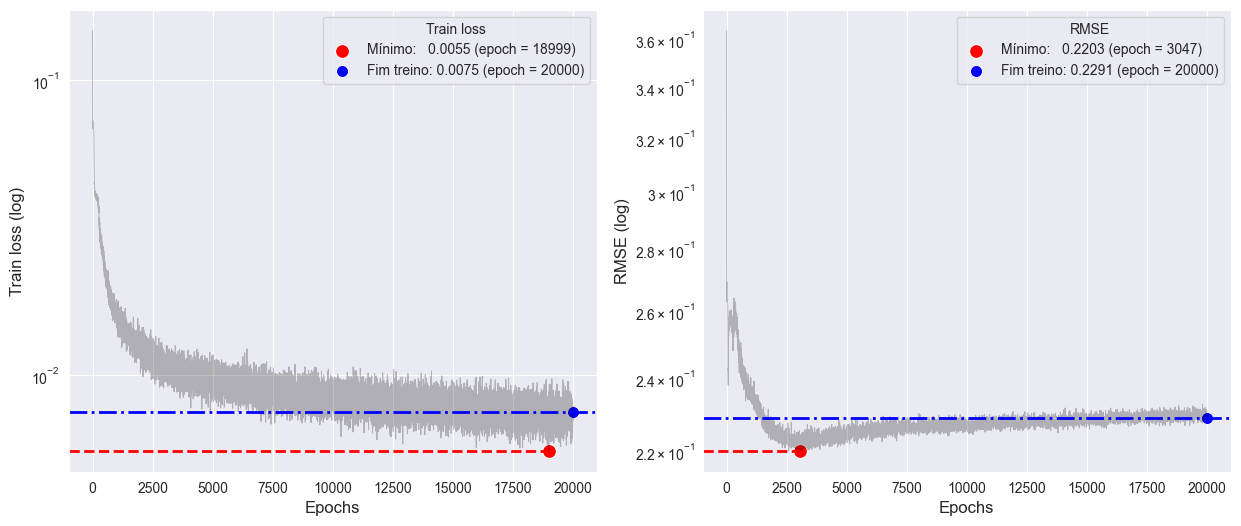

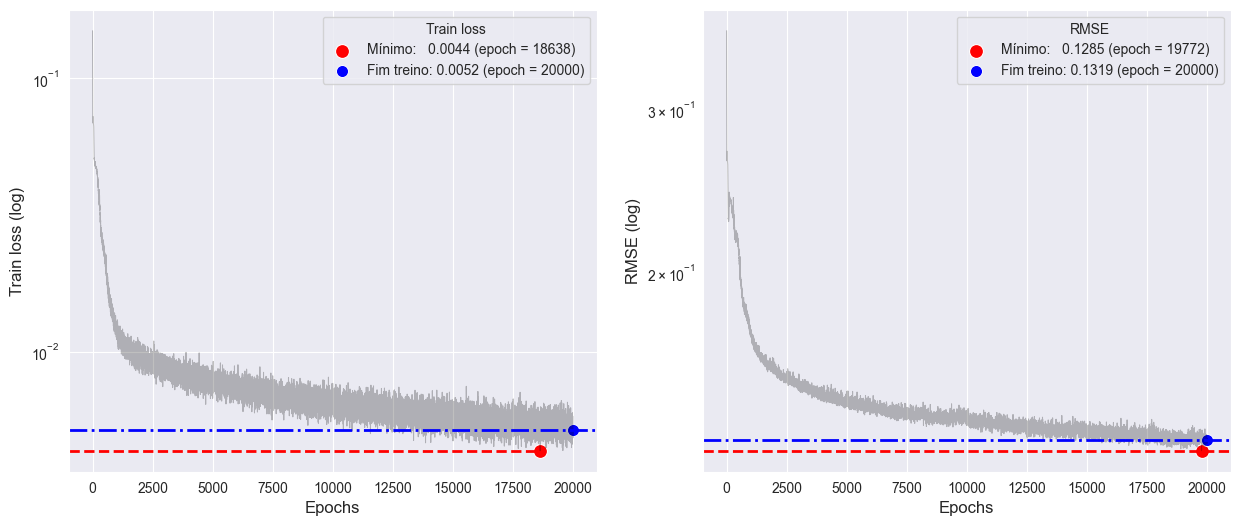

In [4]:
plot_learning(exp.dict_metadata, 0, "concrete", 0.3)
plot_learning(exp.dict_metadata, 0, "concrete", 0.7)

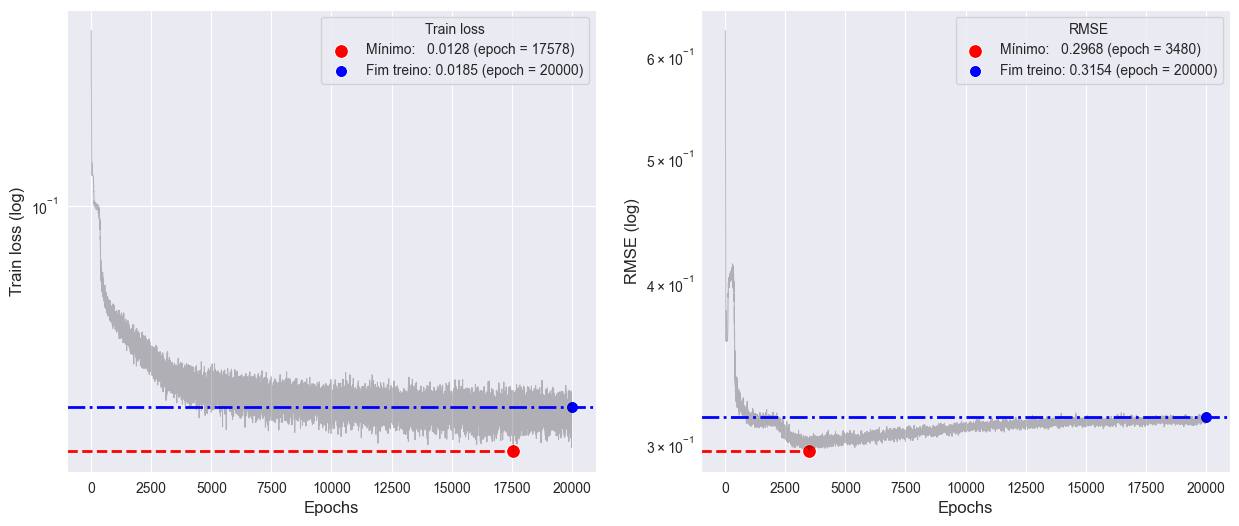

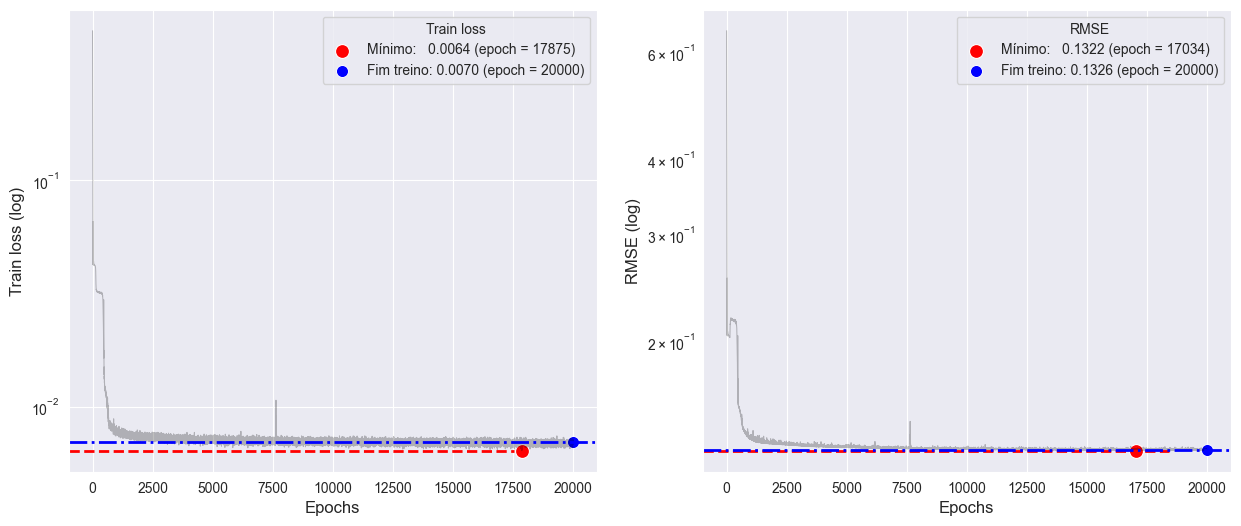

In [5]:
plot_learning(exp.dict_metadata, 0, "energy", 0.3)
plot_learning(exp.dict_metadata, 0, "power", 0.7)

## Hiperparameters

Função de ativação  : [Relu, Prelu]
Otimizador          : [Adam, RMSprop]
Learning rate       : [0.01*, 0.001, 0.005] 

Estudo conduzido para casos extremos: 10% e 70% de valores faltantes
Métricas            : [MAE, RMSE]

Prelu_Adam_0.005 atingiu melhores resultados para poucos dados faltantes (10%) mas em geral todos (exceto LR=0.01 e Prelu_Rmsprop_0.005) performaram de forma similar com muitos dados faltantes (70%) em ambas as métricas

Por critério de tempo de execução foi adotado (taxa de aprendizado maior pois reduziu epochs para 12000):
Função de ativação  : [Relu]
Otimizador          : [Adam]
Learning rate       : [0.005] 

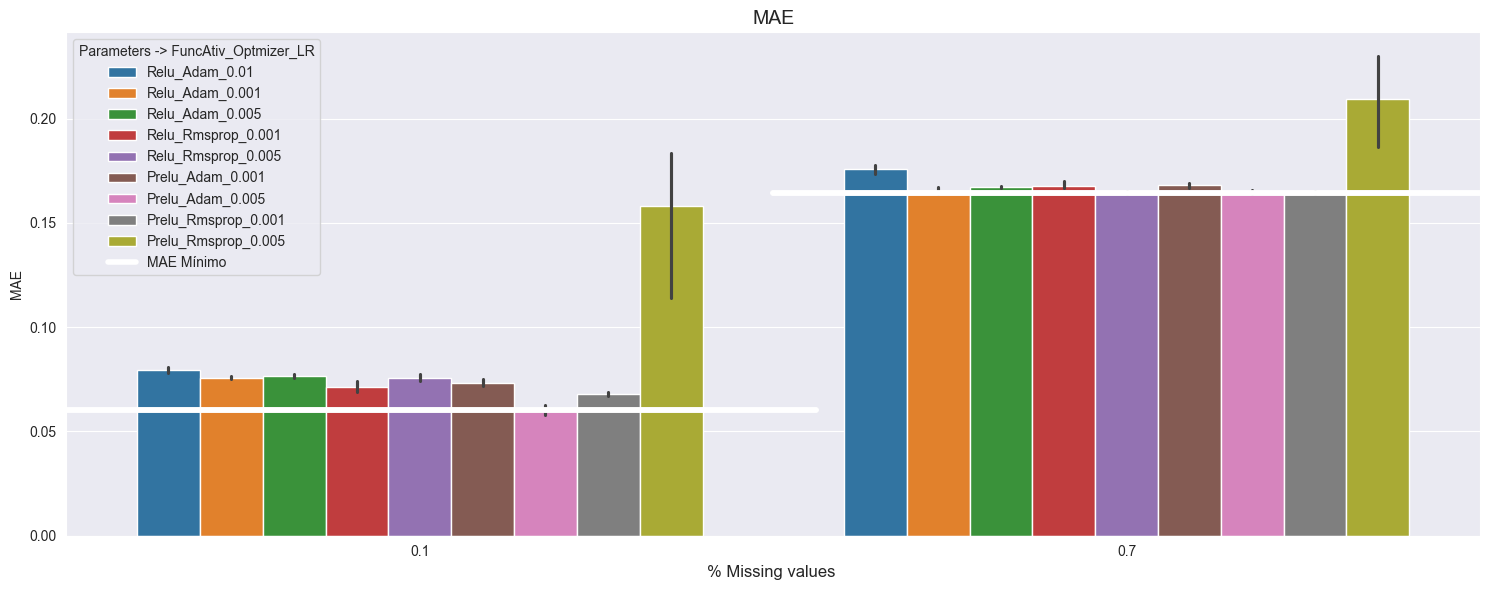

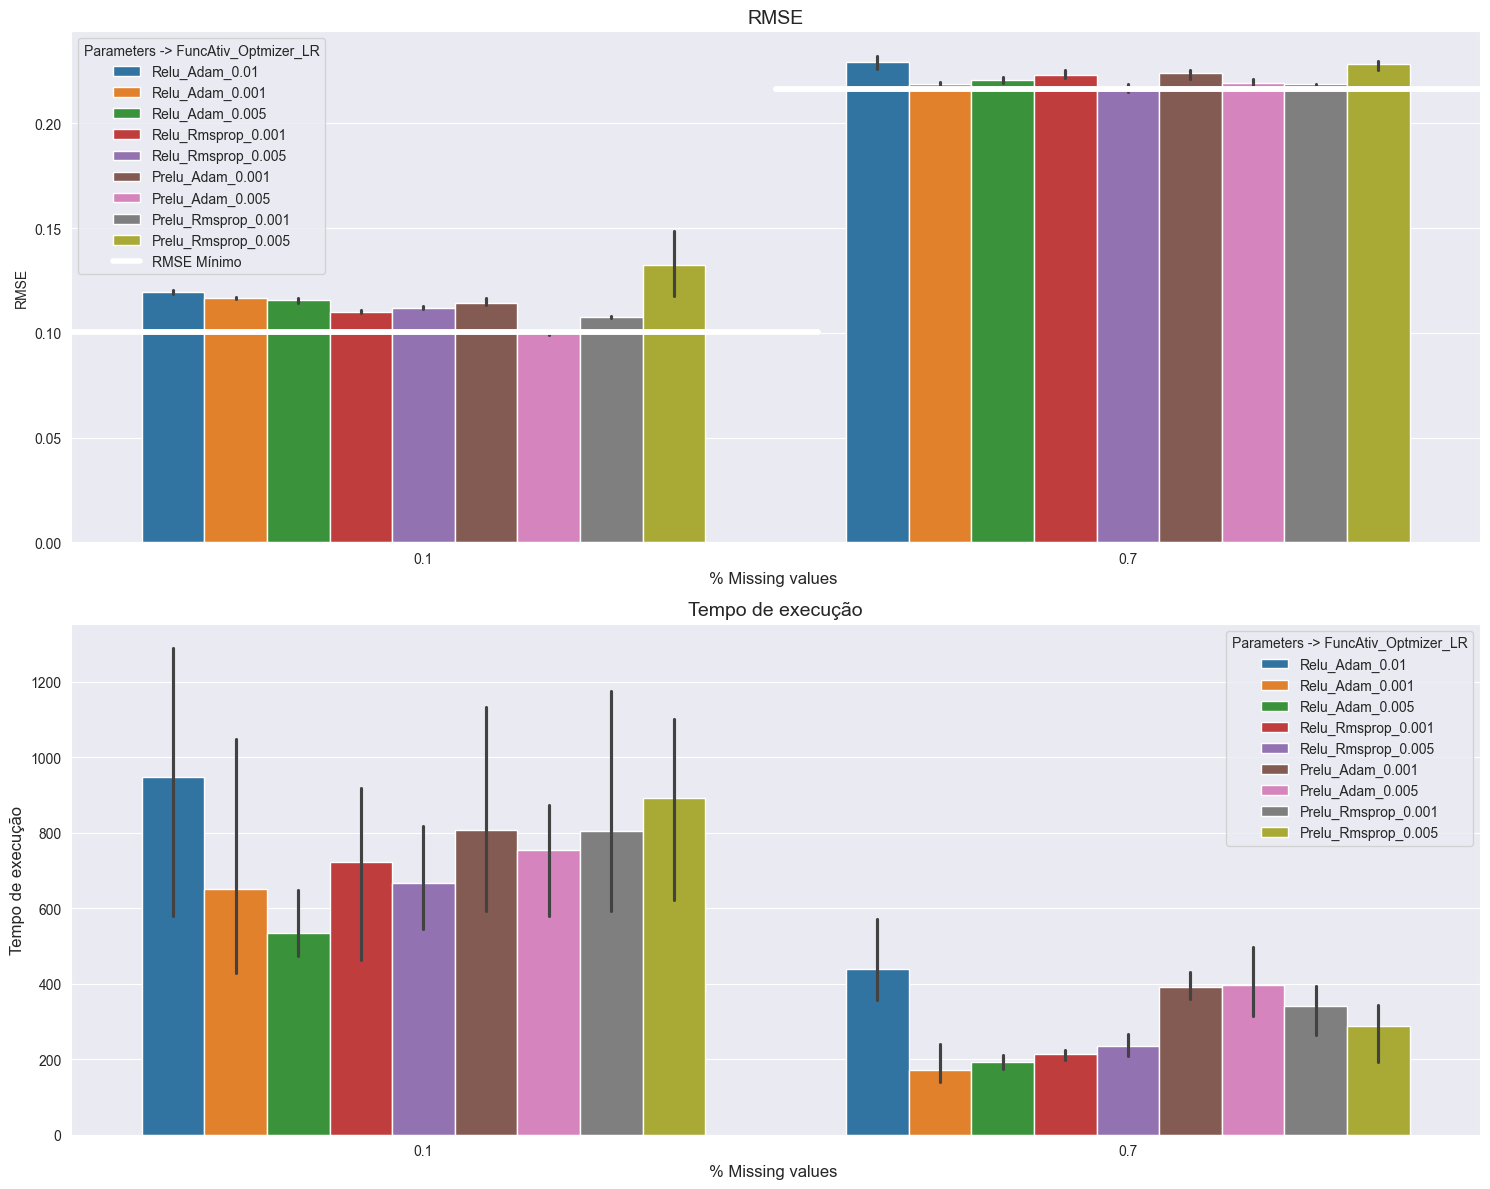

In [6]:
gnn_model.plot_params_gnn(metric = 'MAE', plot_time = False)
gnn_model.plot_params_gnn(metric = 'RMSE')

# Visualização datasets

Tentativa de visualização da similaridade dos datasets via PCA com 3 componentes, explica bem Energy e pouco (~20%) dos demais, mas é possivel ver que datasets escolhidos fornecem relativa diversidade para os testes  (os dois co pouca variancia explicada diferem em tamanho concreto com 1000 elementos e power com 10000 elementos)

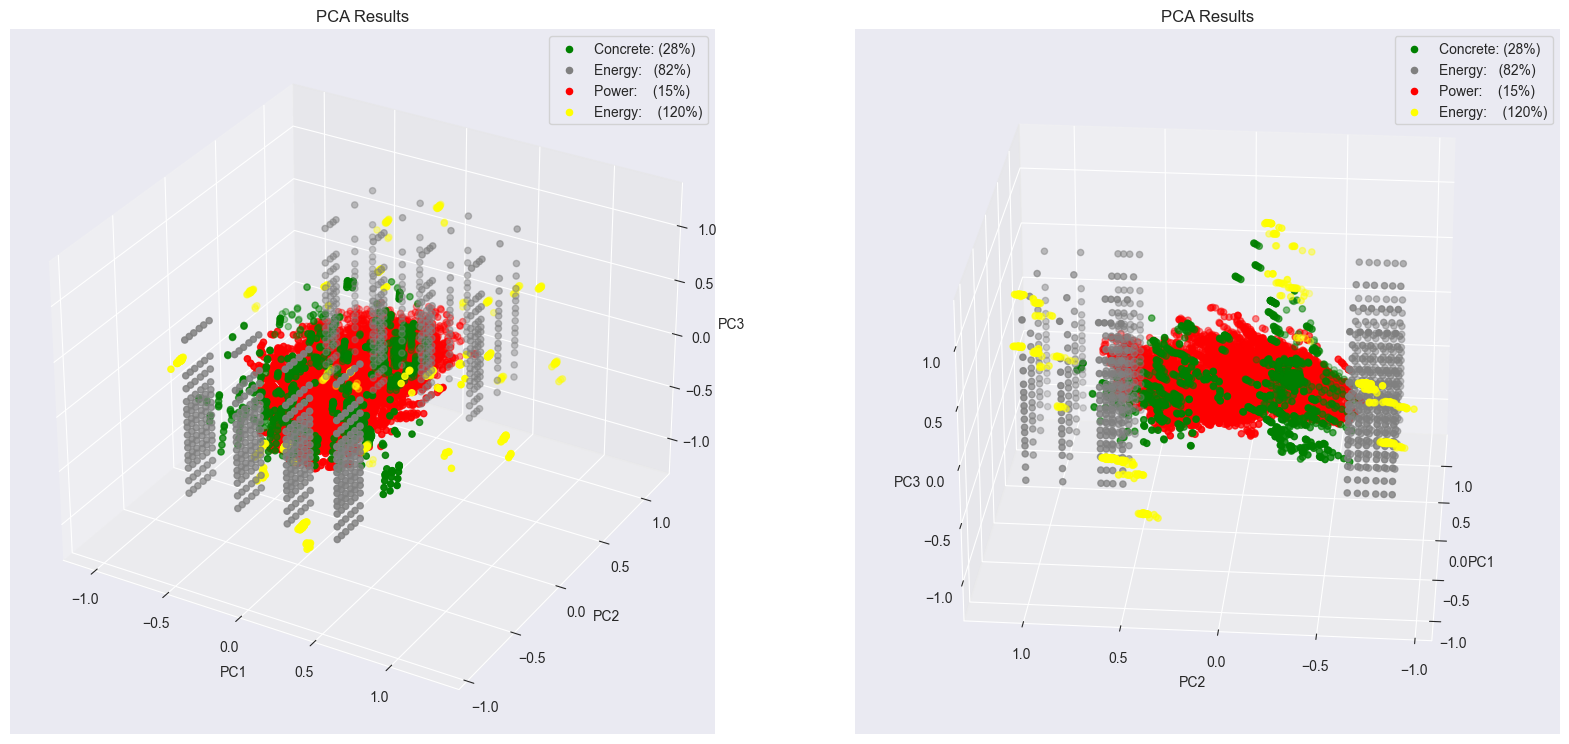

In [7]:
view_pca(exp.data_dict)

# Análise métodos de Imputação

Utilizados métodos (sem otimização):
- Média
- KNN
- MICE
- SVD
- Spectral (explicar -> fancyimputer)

Comparado com GRAPE (GNN sem otimização)

Melhores: GNN - MICE - KNN

RMSE: GRAPE sempre melhor, MICE é baseline em quase todos

MAE: dataset grande(power) com 50% média melhor que KNN, MICE continua bom, KNN-> melhorar chute número clusters?

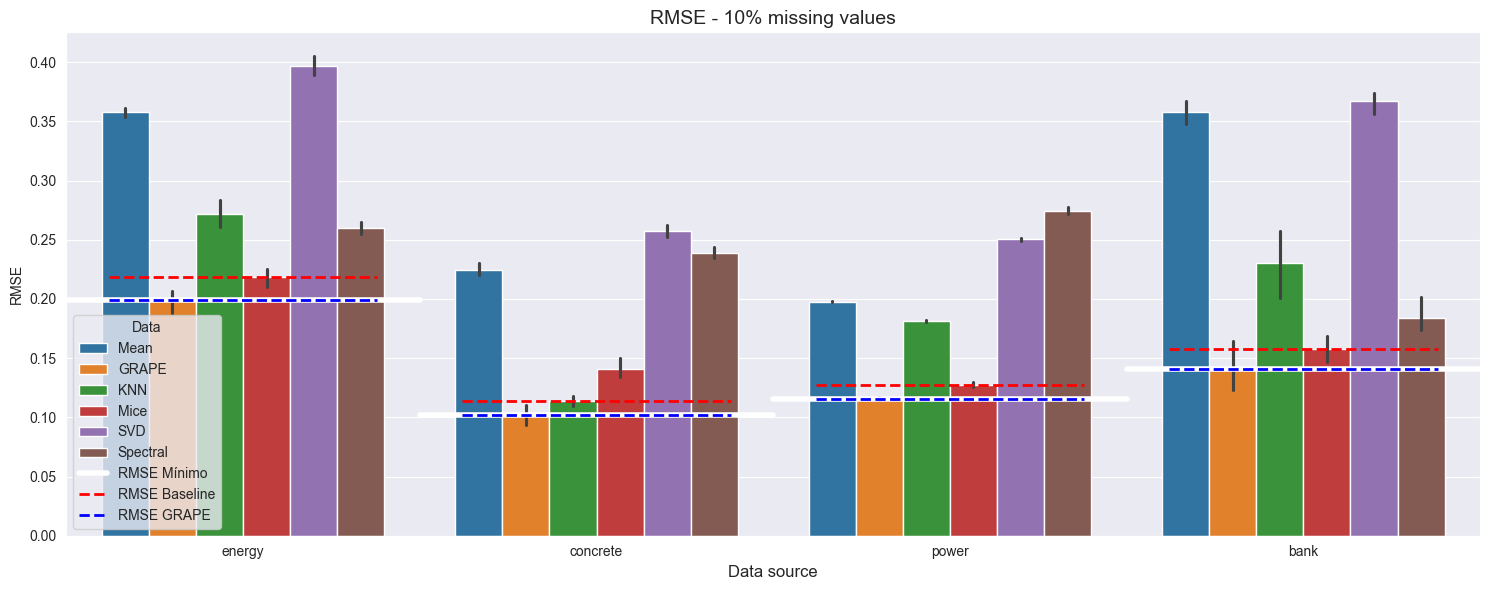

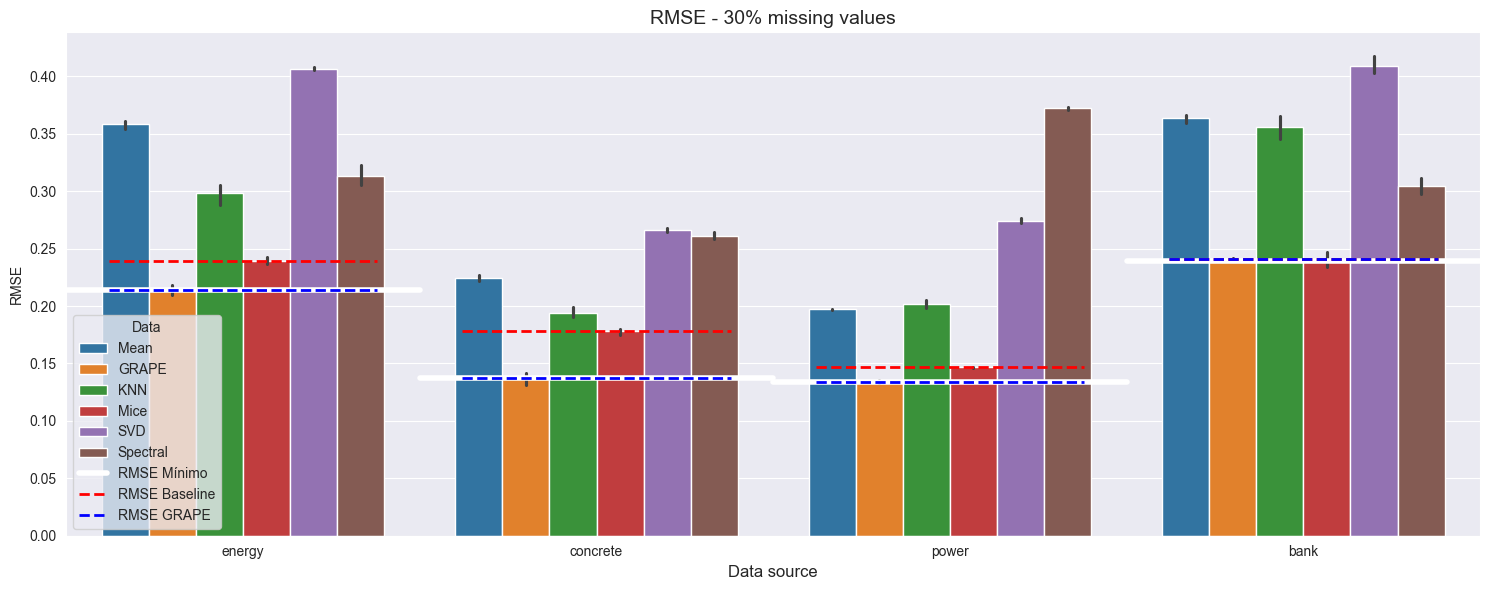

In [19]:
exp.plot_error_bars(metric = 'RMSE', exist_val_percent = 0.90)
exp.plot_error_bars(metric = 'RMSE', exist_val_percent = 0.70)

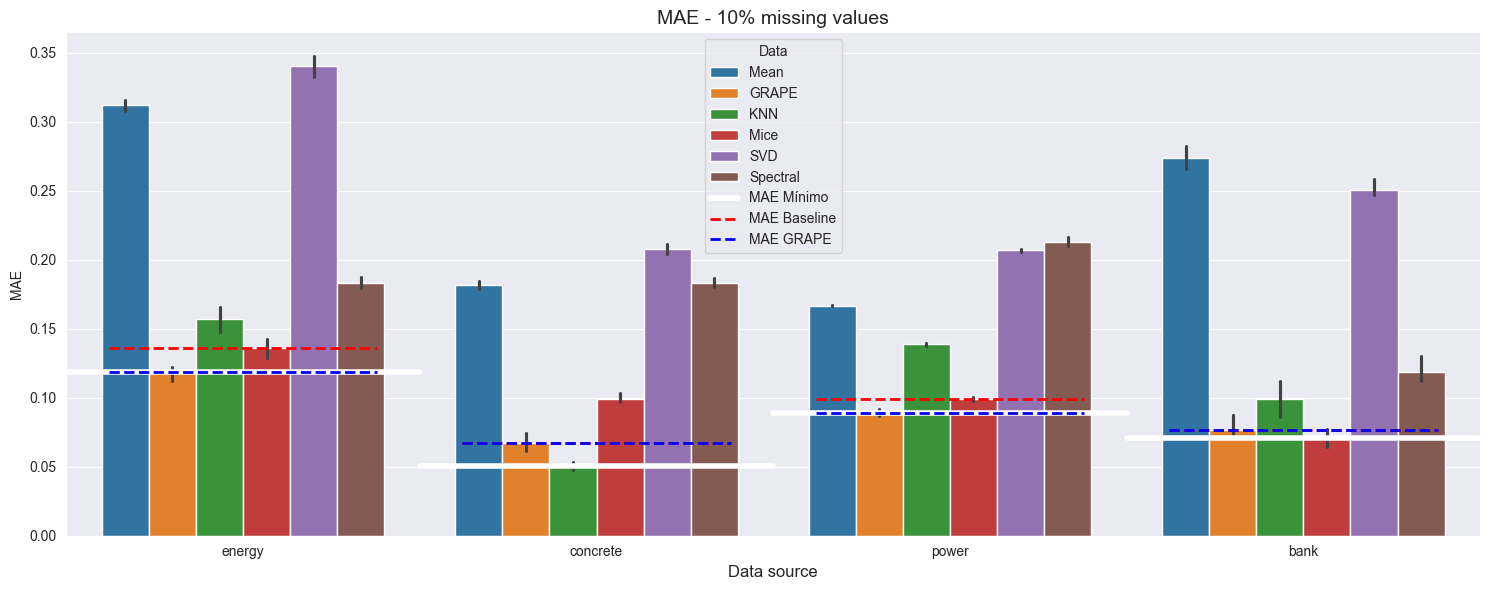

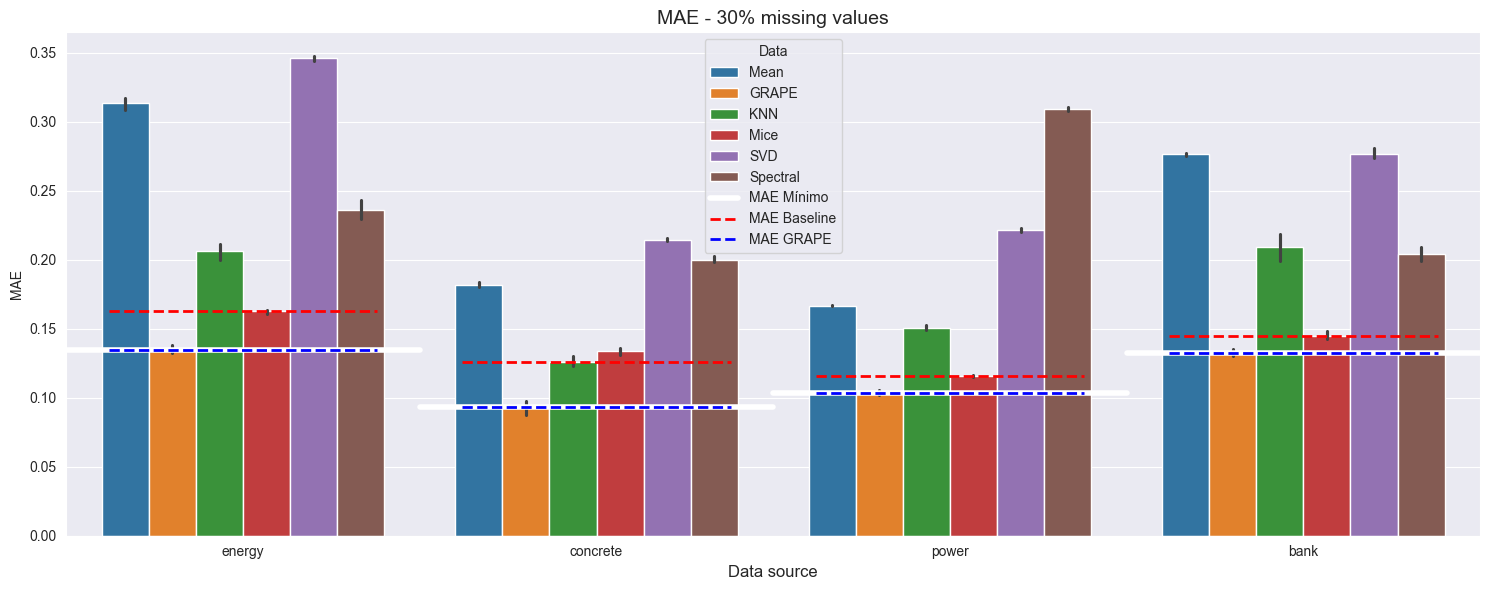

In [20]:
exp.plot_error_bars(metric = 'MAE', exist_val_percent = 0.90)
exp.plot_error_bars(metric = 'MAE', exist_val_percent = 0.70)

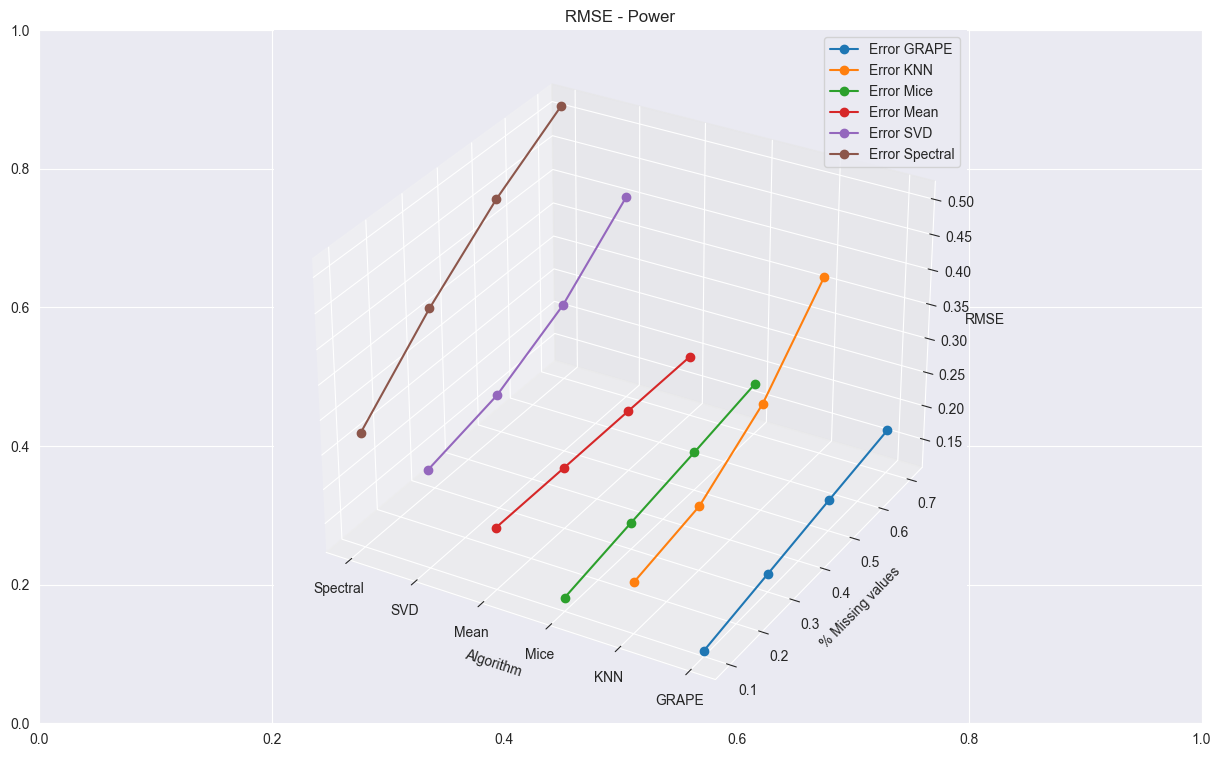

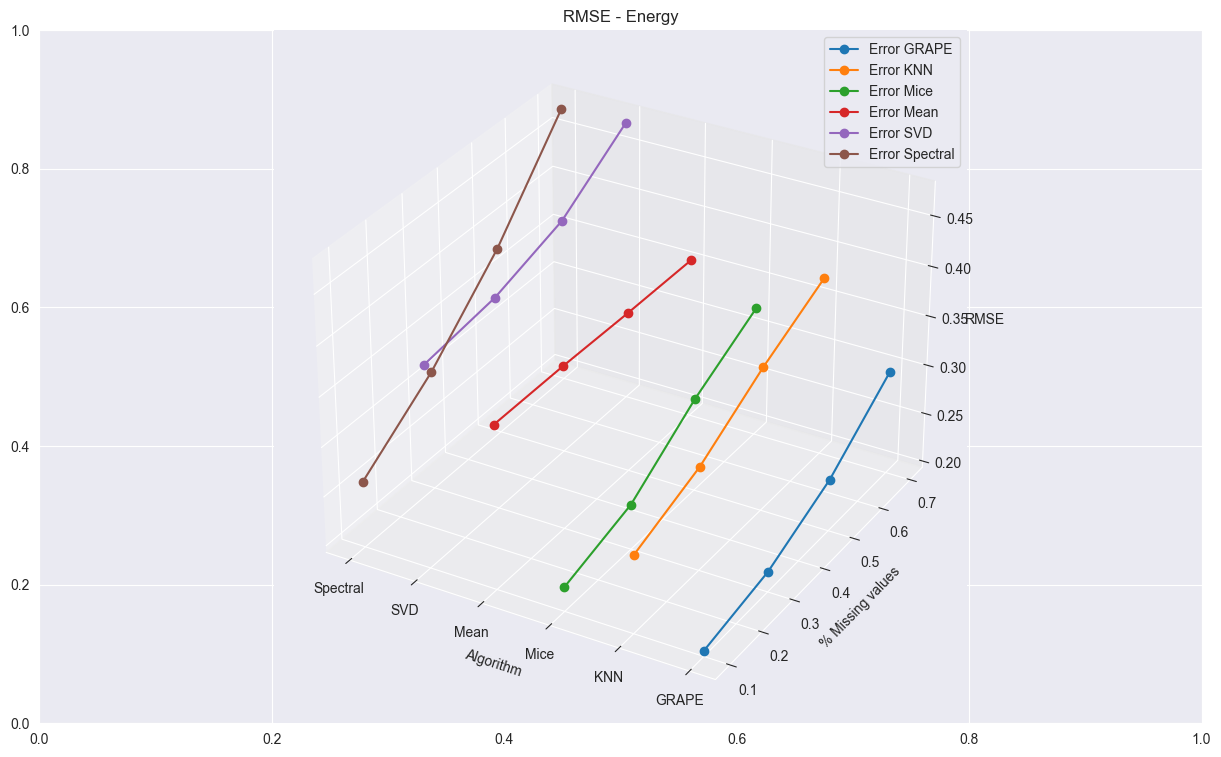

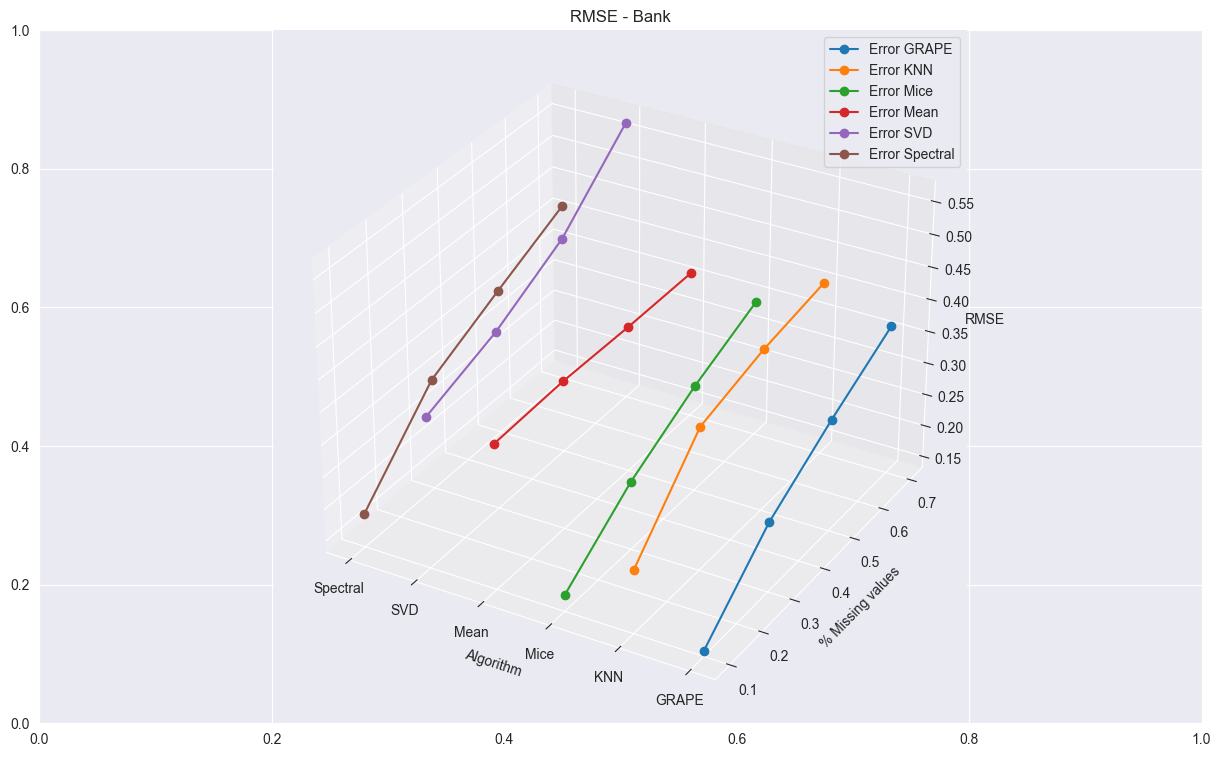

In [22]:
exp.plot_error_line(data = 'power', metric = 'RMSE')
exp.plot_error_line(data = 'energy', metric = 'RMSE')
exp.plot_error_line(data = 'bank', metric = 'RMSE')

# Análise da influência da Imputação na Predição

alg regressão = 
Linear Regression,
Elastic Net CV,
Polynomial Features,
Lasso,*
Decision Tree,
Random Forest,
Gradient Boosting,
KNeighbors Uniform,
KNeighbors Distance

                   
* Aplica Lasso na Polynomial, sendo estimado alpha com CV

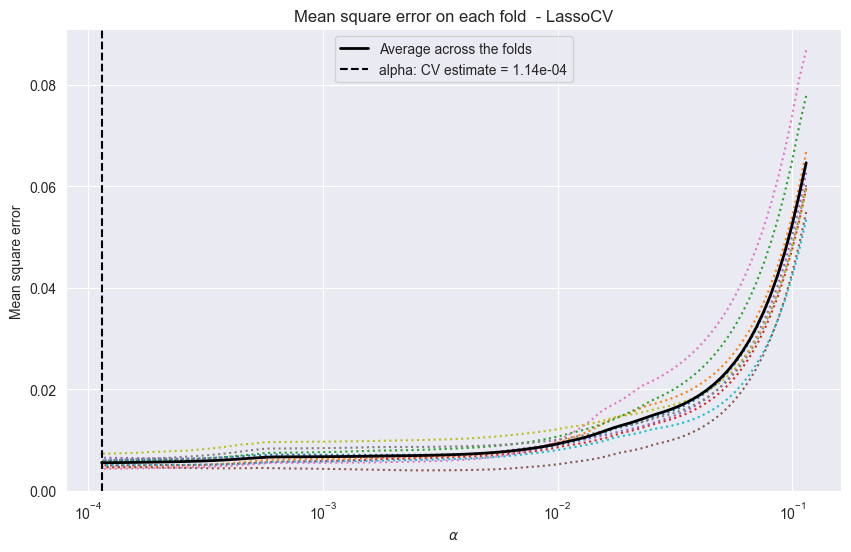

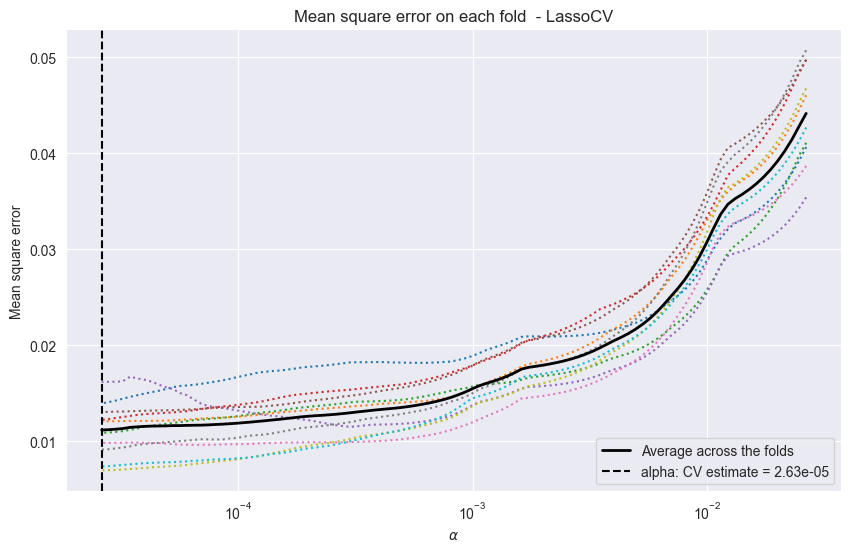

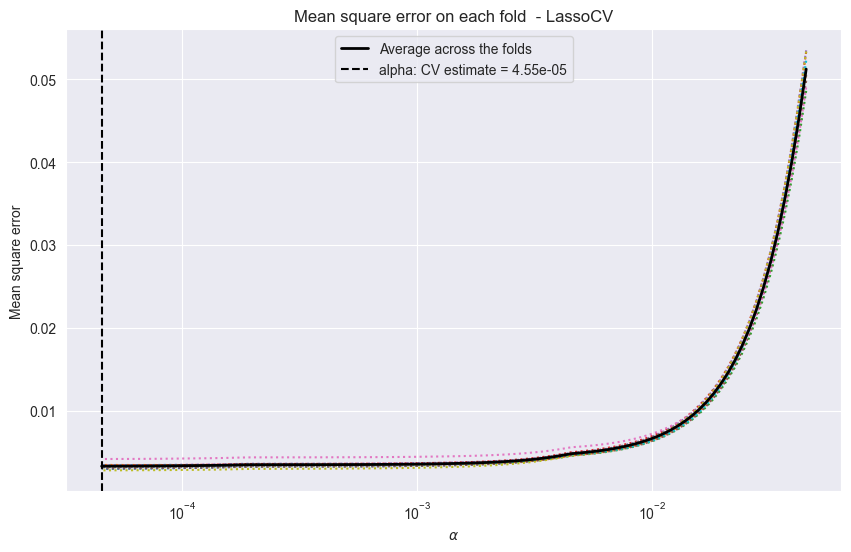

Conjunto de Dados: 'Energy':
Treino:	614	(80%)
Teste:	154	(20%)
Total:	768

Conjunto de Dados: 'Concrete':
Treino:	824	(80%)
Teste:	206	(20%)
Total:	1030

Conjunto de Dados: 'Power':
Treino:	7654	(80%)
Teste:	1914	(20%)
Total:	9568

Conjunto de Dados: 'Bank':
Treino:	400	(80%)
Teste:	100	(20%)
Total:	500


In [9]:
exp_pred.compile_predict()

GRAPE não foi tão bem, treinamento parou cedo demais

Gradient boosting e Random forest generalizaram melhor
Inclusive melhor resultado (RMSE) foi obtido fazendo o input dos valores com a média dos dados

Decision tree ruim sempre -> muito simples

Regressão linear/polinomial muito ruim com os dados que tiverem imputação muito ruim (SVD e spectral) -> ver variância caso polynomial ~100%

Regularização Lasso ajudou muito a regressão poly

Excetuando SVD e spectral, menor erro foi ~300% do erro do conjunto de dados original

Os resultados dos algoritmos baseline de regressão (sem otmização de hiprparâmetros) nos dados gerados por diferentes 

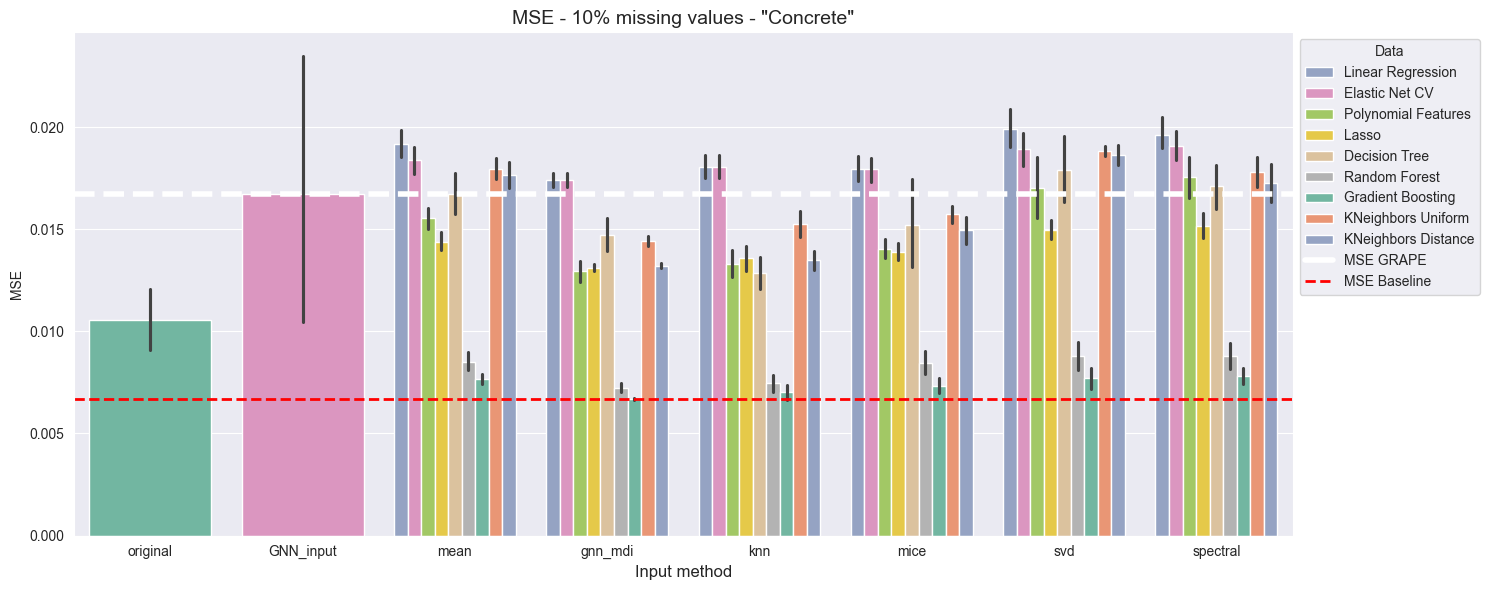

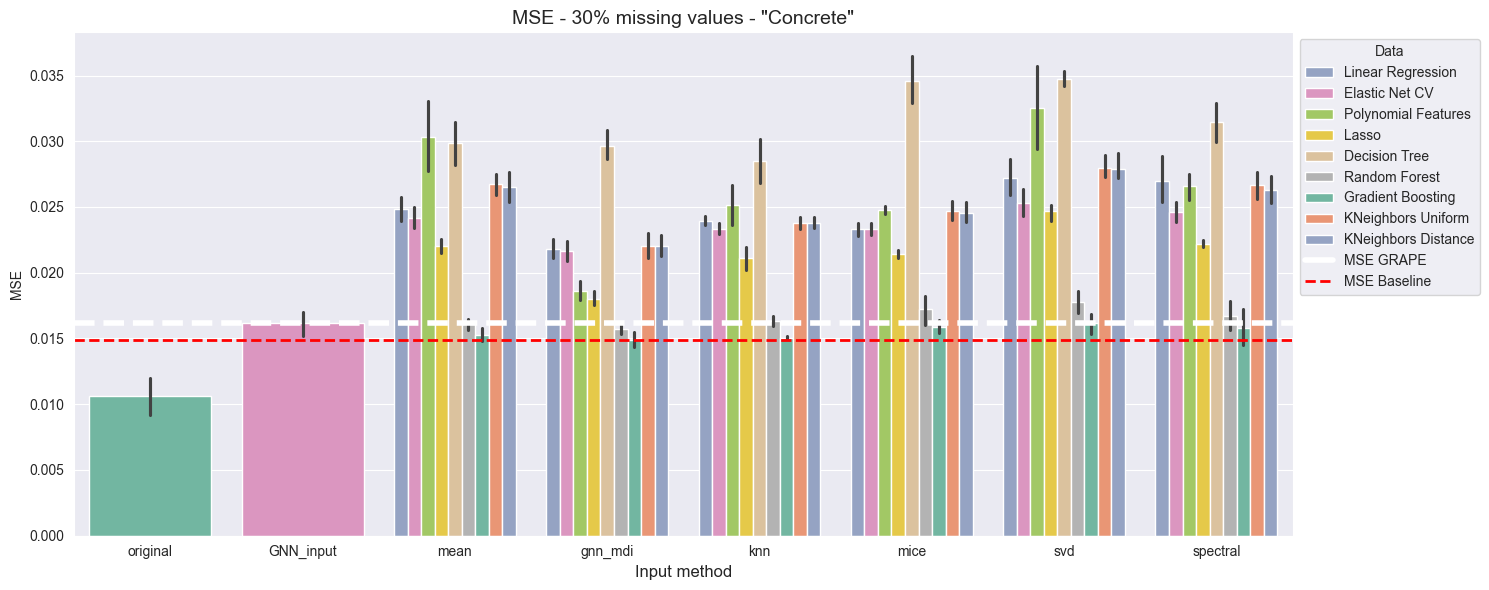

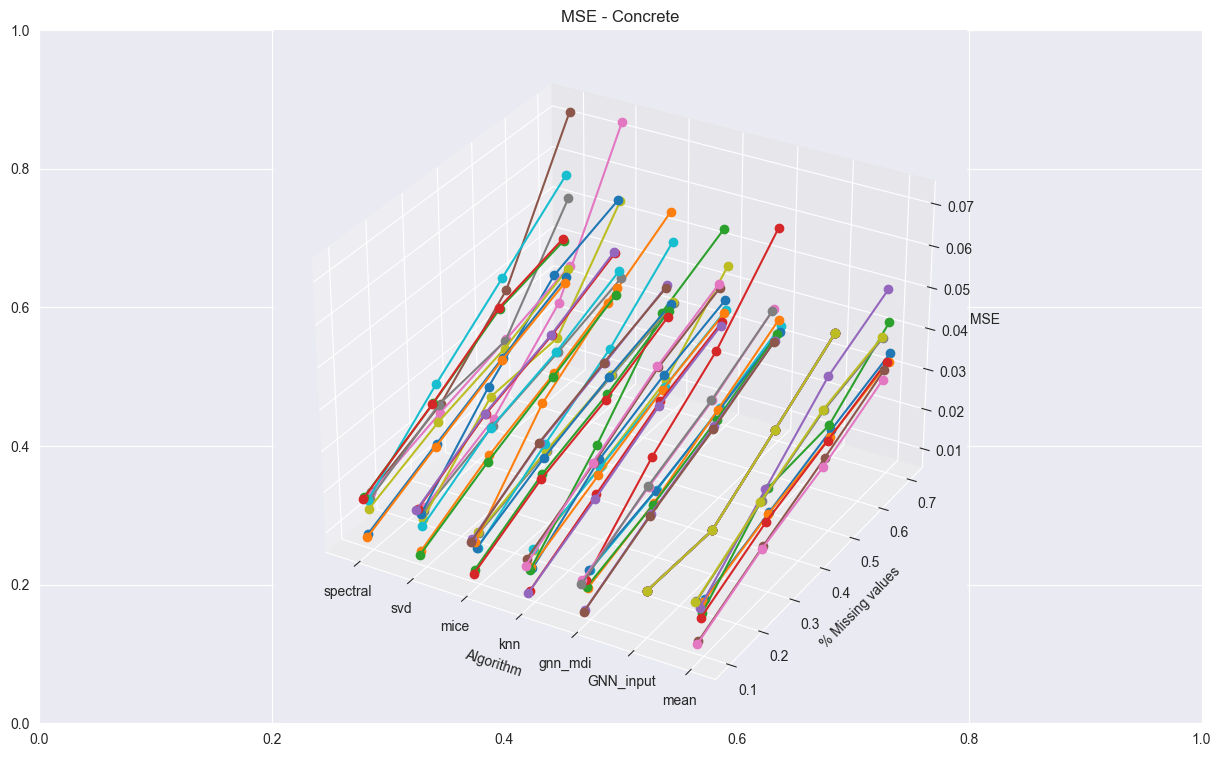

In [17]:
exp_pred.plot_predict_bars("concrete", 0.90, "MSE")
exp_pred.plot_predict_bars("concrete", 0.70, "MSE")
exp_pred.plot_predict_error('concrete', 'MSE')

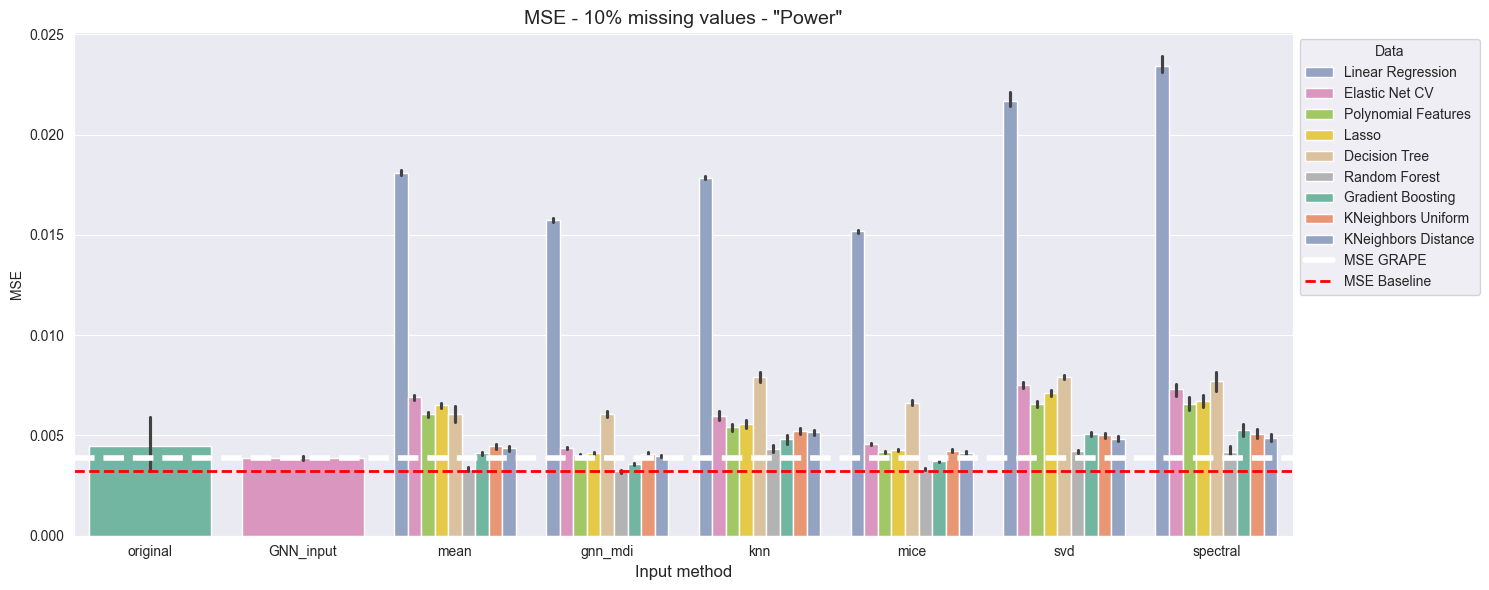

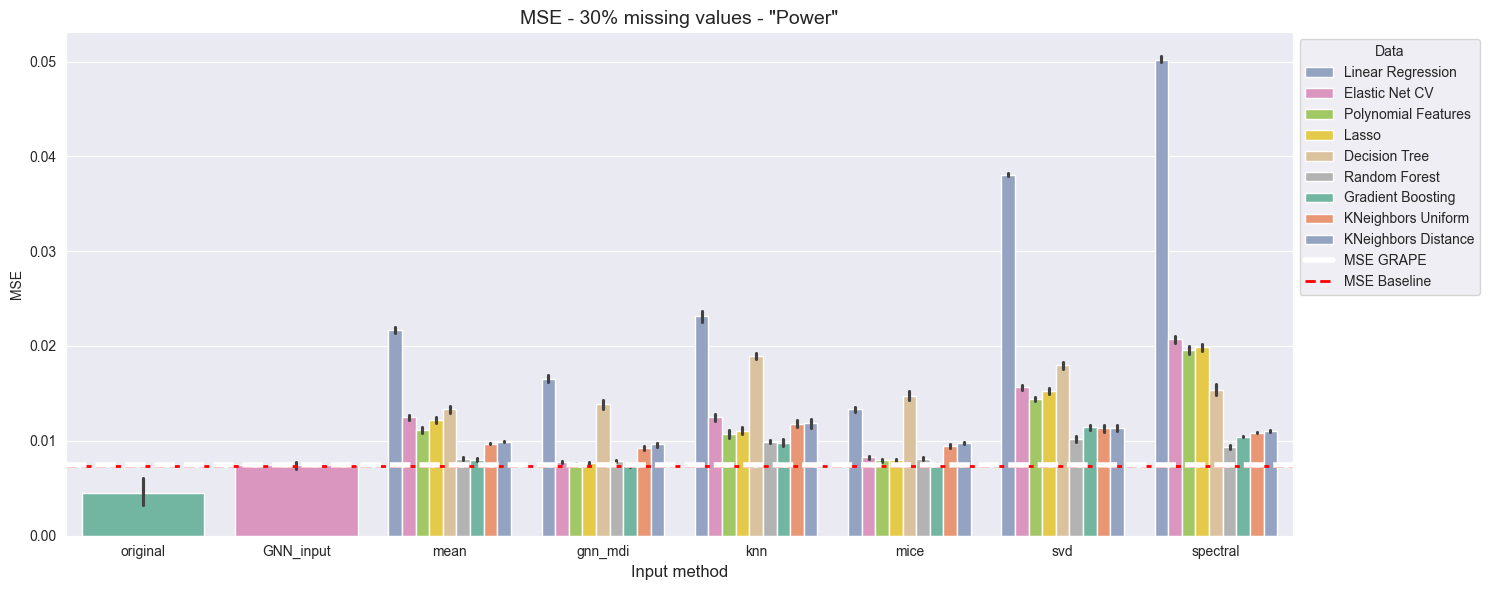

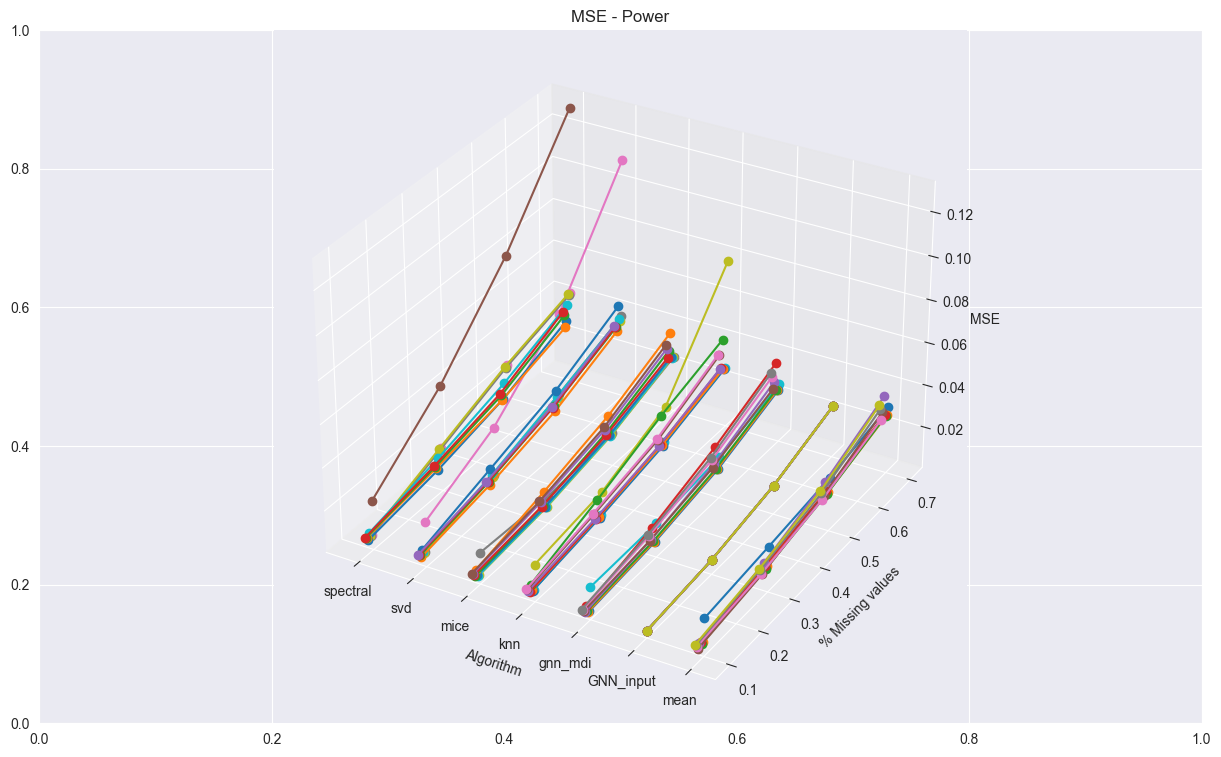

In [18]:
exp_pred.plot_predict_bars("power", 0.90, "MSE")
exp_pred.plot_predict_bars("power", 0.70, "MSE")
exp_pred.plot_predict_error('power', 'MSE')

## Concrete dataset

Cement (component 1) -- quantitative -- kg in a m3 mixture -- Input Variable
Blast Furnace Slag (component 2) -- quantitative -- kg in a m3 mixture -- Input Variable
Fly Ash (component 3) -- quantitative -- kg in a m3 mixture -- Input Variable
Water (component 4) -- quantitative -- kg in a m3 mixture -- Input Variable
Superplasticizer (component 5) -- quantitative -- kg in a m3 mixture -- Input Variable
Coarse Aggregate (component 6) -- quantitative -- kg in a m3 mixture -- Input Variable
Fine Aggregate (component 7) -- quantitative -- kg in a m3 mixture -- Input Variable
Age -- quantitative -- Day (1~365) -- Input Variable

Concrete compressive strength -- quantitative -- MPa

## Energy dataset

X1 Relative Compactness
X2 Surface Area
X3 Wall Area
X4 Roof Area
X5 Overall Height
X6 Orientation
X7 Glazing Area
X8 Glazing Area Distribution

y1 Heating Load
y2 Cooling Load

## Power dataset

Variables:
Temperature (T) in the range 1.81°C and 37.11°C,
Ambient Pressure (AP) in the range 992.89-1033.30 milibar,
Relative Humidity (RH) in the range 25.56% to 100.16%
Exhaust Vacuum (V) in teh range 25.36-81.56 cm Hg

Target:
Net hourly electrical energy output (PE) 420.26-495.76 MW